In [1]:
from warnings import simplefilter 
import os
simplefilter(action='ignore', category=FutureWarning)
os.environ['TF_CPP_MIN_LOG_LEVEL'] = "3" 
os.environ['CUDA_VISIBLE_DEVICES'] = ""

In [2]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from kvae.KalmanVariationalAutoencoder import KalmanVariationalAutoencoder
from kvae.utils import reload_config, get_image_config

%matplotlib inline
plt.style.use("seaborn-white")

In [6]:
logdir = Path("../examples/logs/box_success_kvae/model.ckpt")

In [5]:
!ls ../examples/logs/box_success_kvae/ | grep .ckpt

model.ckpt.data-00000-of-00001
model.ckpt.index
model.ckpt.meta


In [7]:
tf.app.flags.DEFINE_string('f', '', 'kernel')

In [8]:
config = get_image_config()
# To reload a saved model
config = reload_config(config.FLAGS)

In [10]:
config.reload_model = str(logdir)
config.batch_size = 32

In [11]:
sess = tf.Session()
model = KalmanVariationalAutoencoder(config, sess)
model.build_model().build_loss().initialize_variables()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use keras.layers.flatten instead.
Instructions for updating:
This class is equivalent as tf.keras.layers.LSTMCell, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.contrib.distributions`.
Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.contrib.distributions`.
Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.distributions`.
Instructions f

In [12]:
mask_test = np.ones((model.config.batch_size, model.test_data.timesteps), dtype=np.float32)
num_batches = model.test_data.sequences // model.config.batch_size
smooth, a_seq, a_mu, a_var = [], [], [], []
for i in range(num_batches):
    slc = slice(i * model.config.batch_size, (i + 1) * model.config.batch_size)
    feed_dict = {model.x: model.test_data.images[slc],
                 model.kf.u: model.test_data.controls[slc],
                 model.ph_steps: model.test_data.timesteps,
                 model.mask: mask_test}
    smooth_, a_seq_, a_mu_, a_var_ = sess.run(
        [model.model_vars["smooth"][0],
        model.model_vars["a_seq"], 
        model.model_vars["a_mu"], 
        model.model_vars["a_var"]],
        feed_dict=feed_dict)
    smooth.append(smooth_)
    a_seq.append(a_seq_)
    a_mu.append(a_mu_)
    a_var.append(a_var_)

In [17]:
smooth = np.vstack(smooth)
a_seq = np.vstack(a_seq)
a_mu = np.vstack(a_mu)
a_var = np.vstack(a_var)

In [18]:
z_mu = smooth.reshape(-1, 4)

In [19]:
model.enc_shape

[4, 4, 32]

In [20]:
sess.close()

# 分析

In [22]:
from sklearn.decomposition import PCA

## 線形性

In [23]:
states = np.concatenate([model.test_data.state[:32*31], model.test_data.velocity[:32*31]], axis=2)
x_mu = states.reshape(-1, 4)

In [24]:
pca = PCA(2)
a_pca = pca.fit_transform(a_mu)

In [25]:
pca = PCA(4)
z_pca = pca.fit_transform(z_mu)

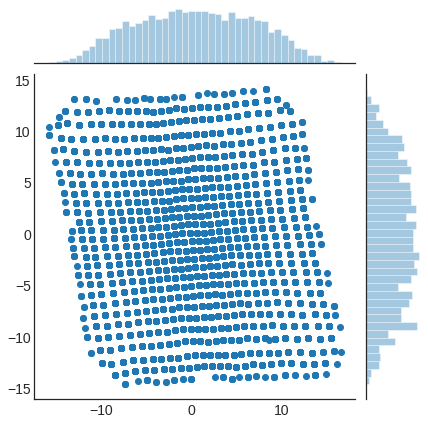

In [26]:
sns.jointplot(*a_mu.T)

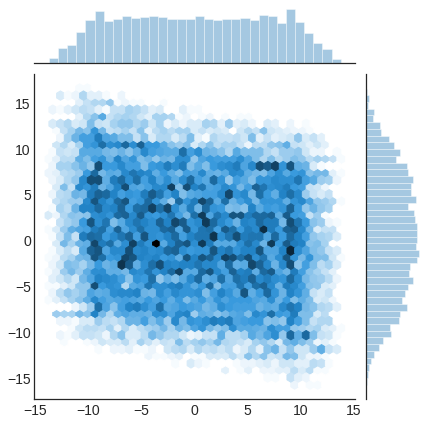

In [27]:
sns.jointplot(x_mu[:, 0], a_mu[:, 0], kind="hex")

(0.0, 10.0, 10.0, 0.0)

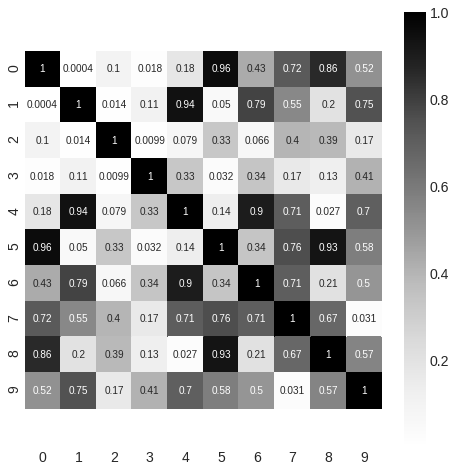

In [28]:
# z_mu
plt.figure(figsize=(8, 8))
R = np.corrcoef(np.hstack([x_mu, a_mu, z_mu]), rowvar=False)
sns.heatmap(np.abs(R), square=True, cmap="Greys", annot=True)
# sns.heatmap(R, square=True, cmap="coolwarm", annot=True)
plt.axis("equal")

(0.0, 10.0, 10.0, 0.0)

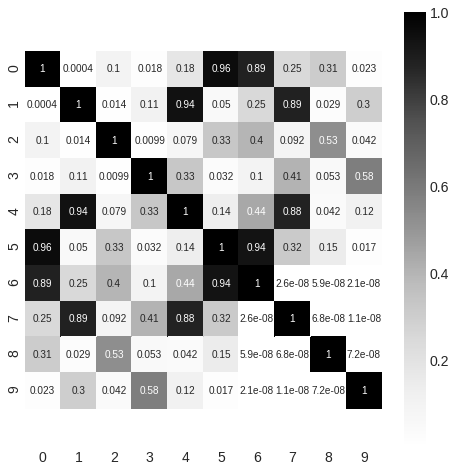

In [29]:
# z_pca
plt.figure(figsize=(8, 8))
R = np.corrcoef(np.hstack([x_mu, a_mu, z_pca]), rowvar=False)
sns.heatmap(np.abs(R), square=True, cmap="Greys", annot=True)
# sns.heatmap(R, square=True, cmap="coolwarm", annot=True)
plt.axis("equal")

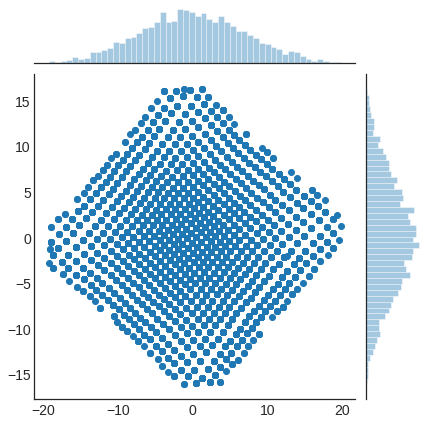

In [30]:
sns.jointplot(*a_pca.T)

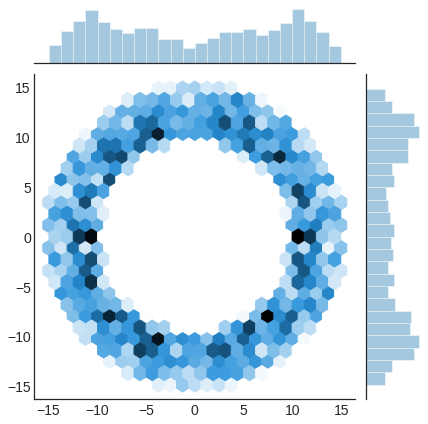

In [37]:
sns.jointplot(*x_mu[:, 2:].T, kind="hex")

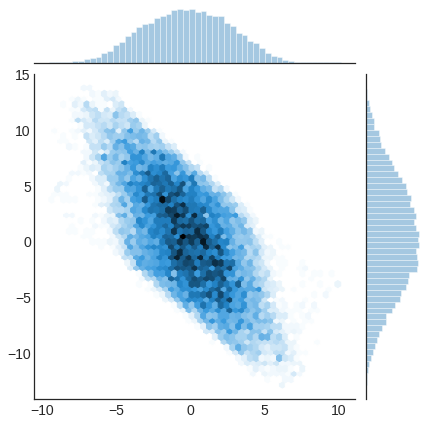

In [32]:
sns.jointplot(*z_mu[:, :2].T, kind="hex")

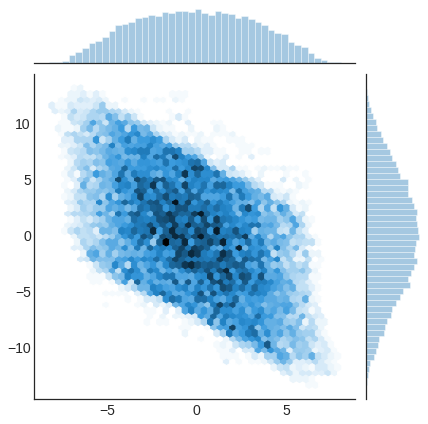

In [42]:
sns.jointplot(*z_mu[:, 2:].T, kind="hex")

In [43]:
def affine(x, y):
    mu_x = np.mean(x, axis=0)
    mu_y = np.mean(y, axis=0)
    ex, ey = x - mu_x, y - mu_y
    cov_xx = np.mean(np.einsum("...i,...j->...ij", ex, ex), axis=0)
    cov_xy = np.mean(np.einsum("...i,...j->...ij", ex, ey), axis=0)
    A = cov_xy.T @ np.linalg.inv(cov_xx)
    b = mu_y - mu_x @ A.T
    return A, b

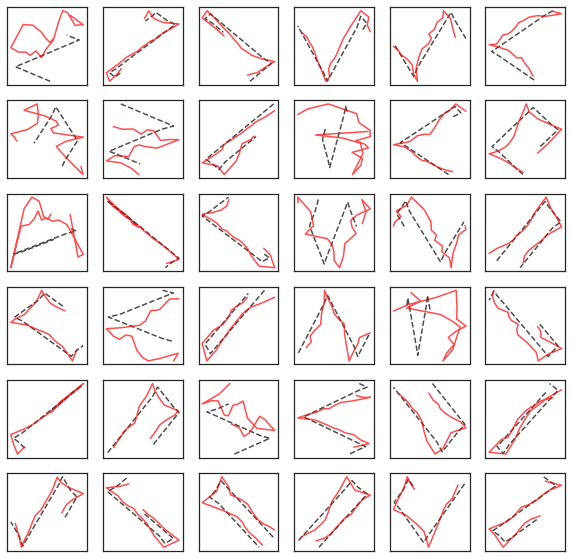

In [51]:
A, b = affine(z_pca, x_mu)
z_affine = z_pca @ A.T + b
h, w = 6, 6
fig, axes = plt.subplots(h, w, figsize=(10, 10))
for i in range(h):
    for j in range(w):
        n = i*w + j
        slc = slice(n*20, (n+1)*20)
        axes[i, j].plot(*x_mu[slc, :2].T, "k--", alpha=0.7)
        axes[i, j].plot(*z_affine[slc, :2].T, "r-", alpha=0.7)
        axes[i, j].set_xticks([])
        axes[i, j].set_yticks([])

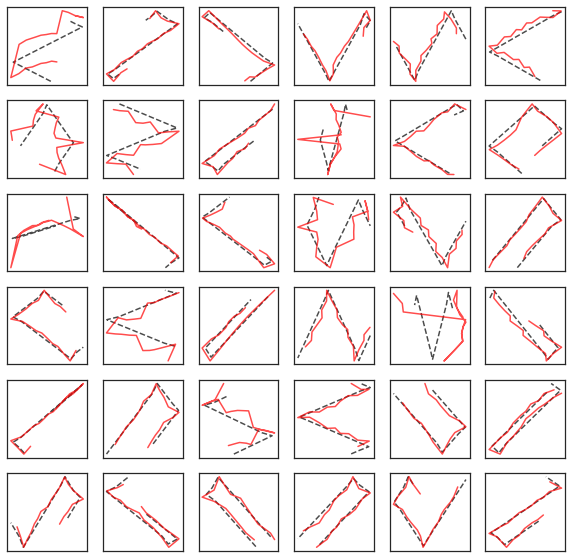

In [52]:
A, b = affine(a_mu, x_mu)
a_affine = a_mu @ A.T + b
h, w = 6, 6
fig, axes = plt.subplots(h, w, figsize=(10, 10))
for i in range(h):
    for j in range(w):
        n = i*w + j
        slc = slice(n*20, (n+1)*20)
        axes[i, j].plot(*x_mu[slc, :2].T, "k--", alpha=0.7)
        axes[i, j].plot(*a_affine[slc, :2].T, "r-", alpha=0.7)
        axes[i, j].set_xticks([])
        axes[i, j].set_yticks([])